In [1]:
import torch

In [10]:
x = torch.rand(4,4)
print(x)

tensor([[0.6716, 0.9939, 0.0437, 0.9773],
        [0.4454, 0.4971, 0.2464, 0.7032],
        [0.8488, 0.7200, 0.5641, 0.9130],
        [0.2073, 0.1577, 0.1407, 0.0057]])


In [14]:
x.view(-1, 2)

tensor([[0.6716, 0.9939],
        [0.0437, 0.9773],
        [0.4454, 0.4971],
        [0.2464, 0.7032],
        [0.8488, 0.7200],
        [0.5641, 0.9130],
        [0.2073, 0.1577],
        [0.1407, 0.0057]])

#library

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Model


__init__(): This method initializes the layers of the network.

The forward method defines the forward pass of the model, which is the process of computing the output predictions given an input tensor.


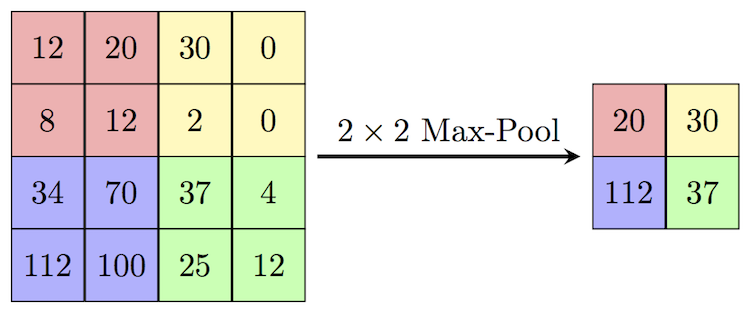

In [47]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1: input channels = 1, output channels = 32, kernel size = 3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Convolutional Layer 2: input channels = 32, output channels = 64, kernel size = 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # MaxPooling Layer: pool size = 2 (downsampling)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer (fully connected to 128 neurons)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Final output layer (for 10 classes, for example)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass through first convolutional layer
        x = self.pool(F.relu(self.conv1(x)))
        # Pass through second convolutional layer
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Pass through fully connected layer 1
        x = F.relu(self.fc1(x))
        # Pass through fully connected layer 2 (output layer)
        x = self.fc2(x)
        return x

Relu activation function :

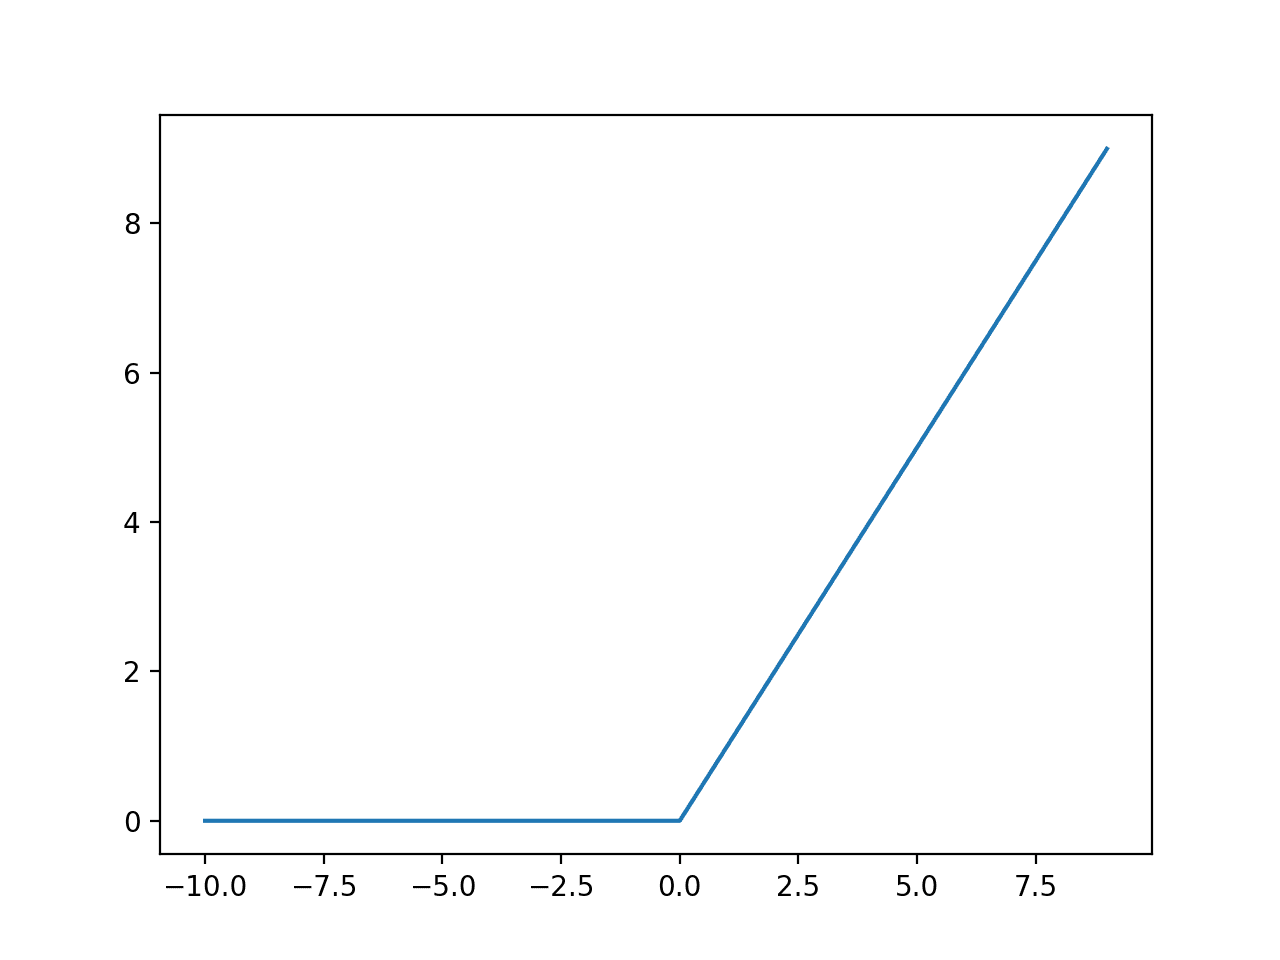

Shape: [batch_size, 64, 7, 7]

batch_size: Number of samples in the batch.

64: Number of feature maps (channels) output by the second convolutional layer.

7 x 7: Spatial dimensions of each feature map after pooling.

In [2]:
pip install torchsummary

In [3]:
from torchsummary import summary

# Assuming model is already defined and moved to the device
model = SimpleCNN().cuda()  # Use .cuda() if you're using a GPU
summary(model, (1, 28, 28))  # Input shape for MNIST images (28x28 grayscale)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


transforms.ToTensor() ---> chnage format to tensor

transforms.Normalize --> normalize to [-1,1]  mean = 0.5 and std= 0.5

In [48]:
# Define transformations (for normalization of MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [49]:
# Load dataset (MNIST in this case)
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch size = number of data use in epoch training

shuffle ---> good slotion for better learning

In [50]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

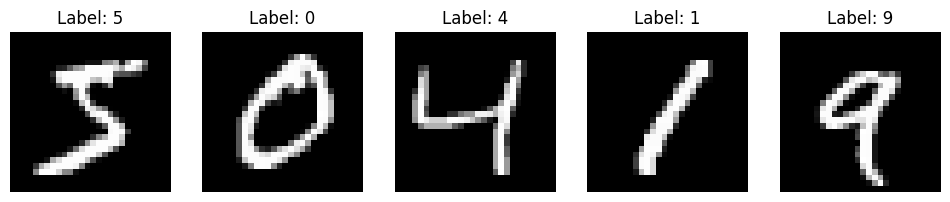

In [51]:
# Sample Data from Training Set - Show a few images
sample_data_train = trainset.data[:5]  # Get the first 5 images from the training set
sample_labels_train = trainset.targets[:5]  # Corresponding labels

# Plot the sample images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(sample_data_train[i].numpy(), cmap='gray')  # Convert the tensor to numpy for plotting
    ax.set_title(f'Label: {sample_labels_train[i].item()}')
    ax.axis('off')

plt.show()

Crossentropy use softmax in output layer for classification

In [52]:
# Instantiate the model, define loss function and optimizer
model = SimpleCNN().cuda()  # Use GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU if available

        # Zero the gradients
        optimizer.zero_grad()
        #Zeroing the gradients (optimizer.zero_grad()): Clears the old gradients,
        # so that the gradients from the current batch can be stored in the model parameters.

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward() # loss cal from backward
        optimizer.step() #update model from backward

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

Epoch [1/5], Loss: 0.0150
Epoch [2/5], Loss: 0.0110
Epoch [3/5], Loss: 0.0094
Epoch [4/5], Loss: 0.0086
Epoch [5/5], Loss: 0.0088


In [54]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        #Model Prediction: The model outputs are computed and the predicted class labels
        # are extracted using torch.max(outputs, 1). This gives the index of the highest
        #score for each input, which corresponds to the predicted class.
        all_labels.extend(labels.cpu().numpy())  # Convert tensor to numpy array
        all_predictions.extend(predicted.cpu().numpy())



In [55]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_predictions)
report = classification_report(all_labels, all_predictions)

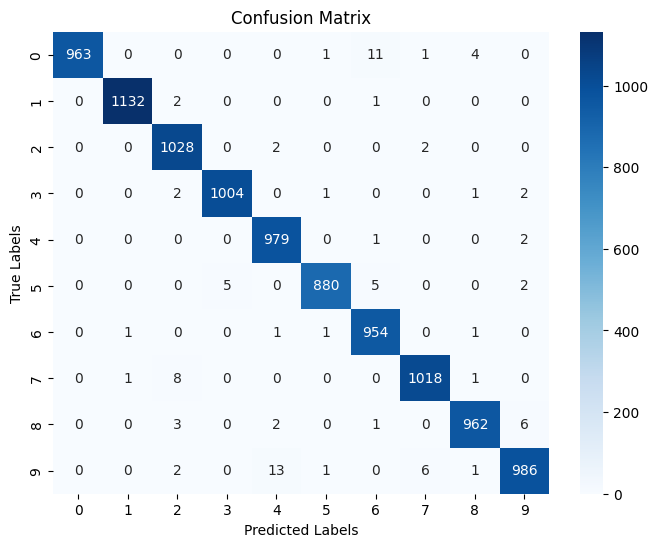

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       0.98      1.00      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [56]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:\n")
print(report)

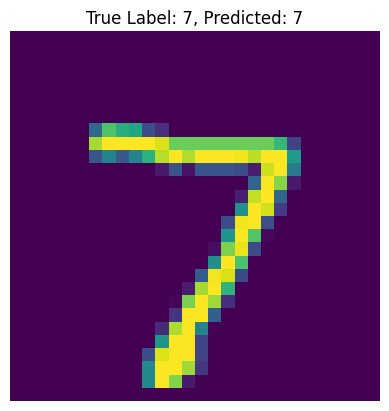

Prediction is correct for this image: 7


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images and labels to GPU if available
images, labels = images.cuda(), labels.cuda()

# Get predictions from the model
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the first image from the batch
img = images[0].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy array for plotting
img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize image for better display

# Display the image along with the true and predicted labels
plt.imshow(img)
plt.title(f"True Label: {labels[0].item()}, Predicted: {predicted[0].item()}")
plt.axis('off')
plt.show()

# Print whether the prediction is correct
if predicted[0] == labels[0]:
    print(f"Prediction is correct for this image: {predicted[0].item()}")
else:
    print(f"Prediction is incorrect. True label: {labels[0].item()}, Predicted: {predicted[0].item()}")

#Resnet

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchsummary import summary

is used to normalize the input images in a way that makes them compatible with the pre-trained models (like VGG, ResNet, etc.) which were trained on the ImageNet dataset.

The mean and std parameters represent the mean and standard deviation of the ImageNet dataset for each color channel (Red, Green, Blue).

In [29]:
# Define transformations for the dataset (normalizing with the same mean and std used in pre-training)
transform = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [23]:
# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


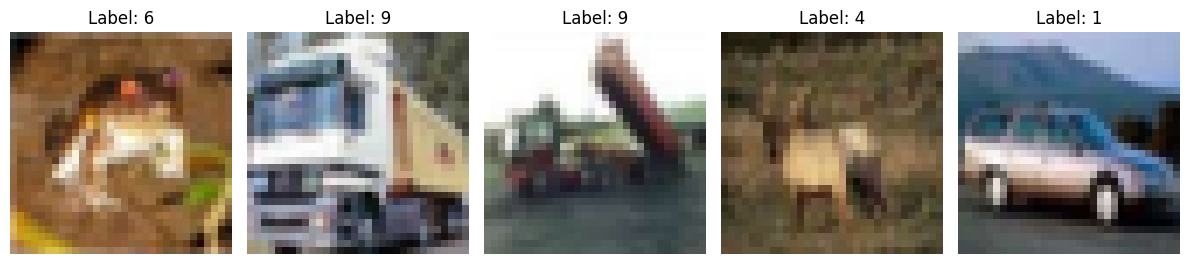

In [35]:
import matplotlib.pyplot as plt

# Select sample data and labels from the training dataset
sample_data_train = trainset.data[:5]  # Get the first 5 images from the training dataset
sample_labels_train = trainset.targets[:5]  # Corresponding labels

# Plot the sample images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(sample_data_train[i], cmap='gray')  # Directly plot the NumPy array
    ax.set_title(f'Label: {sample_labels_train[i]}')  # Use the integer value directly
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


CIFAR 10 Dataset:

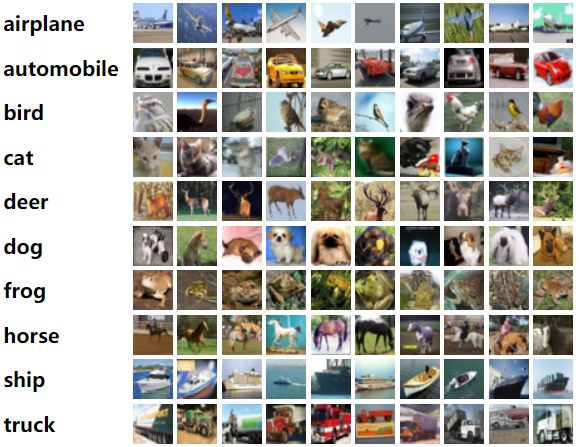

In [24]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to suit CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
summary(model, (3, 224, 224))  # Input size for CIFAR-10 after resizing

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

Epoch [1/2], Loss: 0.3518
Epoch [2/2], Loss: 0.2383


Accuracy of the model on the test images: 87.31%
Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.94      0.88      1000
  automobile       0.91      0.95      0.93      1000
        bird       0.92      0.78      0.84      1000
         cat       0.70      0.81      0.75      1000
        deer       0.95      0.85      0.89      1000
         dog       0.81      0.81      0.81      1000
        frog       0.85      0.96      0.90      1000
       horse       0.95      0.84      0.89      1000
        ship       0.93      0.92      0.92      1000
       truck       0.96      0.87      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



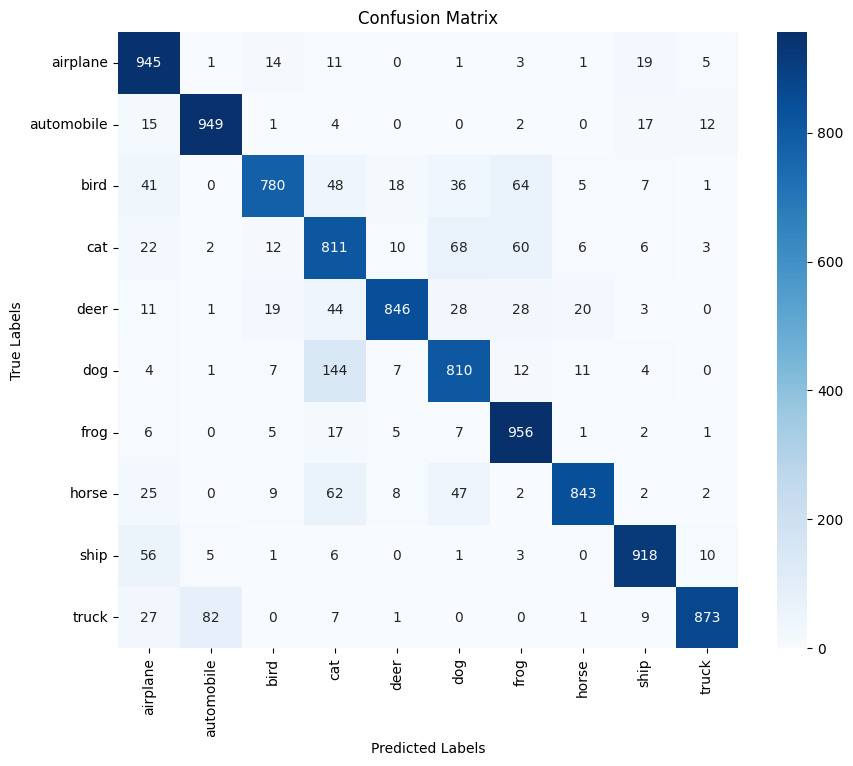

In [30]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=trainset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

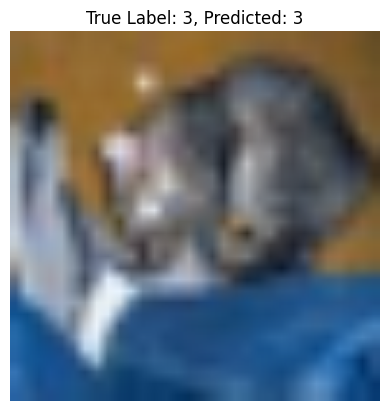

In [31]:
# Show a sample image with its prediction
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display the first image with the true label and predicted label
img = images[0].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy for displaying
img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize for display

plt.imshow(img)
plt.title(f"True Label: {labels[0].item()}, Predicted: {predicted[0].item()}")
plt.axis('off')
plt.show()

#Transfer learning

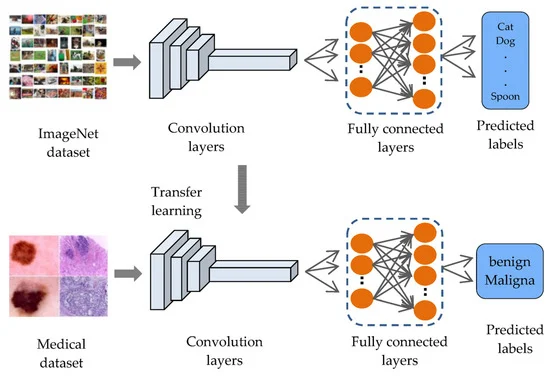

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [37]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match VGG-16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as VGG-16 expects
])

In [38]:
# Load a dataset (e.g., CIFAR-10)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


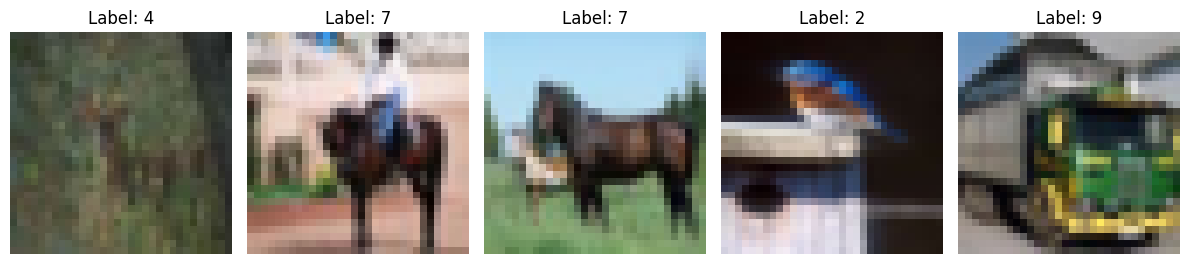

In [40]:
import matplotlib.pyplot as plt

# Select sample data and labels from the training dataset
sample_data_train = trainset.data[10:15]  # Get the first 5 images from the training dataset
sample_labels_train = trainset.targets[10:15]  # Corresponding labels

# Plot the sample images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(sample_data_train[i], cmap='gray')  # Directly plot the NumPy array
    ax.set_title(f'Label: {sample_labels_train[i]}')  # Use the integer value directly
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

in_features=4096 ---> output channel or feature

In [41]:
# Load the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers of the pre-trained model
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier for the new dataset (10 classes for CIFAR-10)
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=10)
 # Replace last layer  and freez final fuly connected layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 69.2MB/s]


In [42]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = vgg16.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)  # Only train the classifier

In [44]:
# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/2], Loss: 0.8597
Epoch [2/2], Loss: 0.6557


In [45]:
# Evaluate the model
vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 83.17%


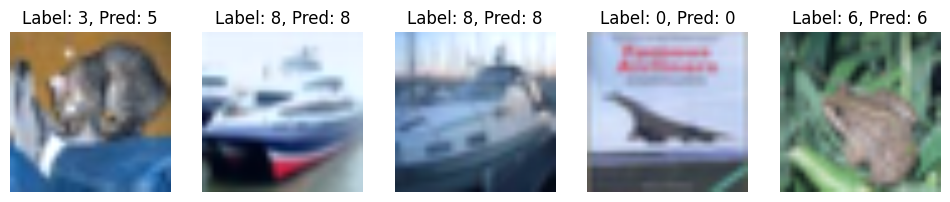

In [46]:
# Display a few predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = vgg16(images)
_, preds = torch.max(outputs, 1)

# Plot the results
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Unnormalize
    ax.set_title(f'Label: {labels[i].item()}, Pred: {preds[i].item()}')
    ax.axis('off')
plt.show()









